# Fault Detection Model Trial Notebook

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Load data

In [2]:
from data.prep import DataPreprocessor
from data.config import DataConfig

data_config = DataConfig(run_type='train')
data_preprocessor = DataPreprocessor("fault_detection")

# Load the data
train_data, test_data, _, = data_preprocessor.get_training_data_package(data_config, batch_size=1)

# unpack data_loaders and data_stats
train_loader = train_data[0]
test_loader = test_data[0]

train_data_stats = train_data[1]
test_data_stats = test_data[1]

# train_loader, train_data_stats = data_preprocessor.get_custom_data_package(data_config, batch_size=1)


'Train' type dataset selected:


ds_subtype selections:

(<ds_subtype_num>) <ds_subtype> : [<augments>]
---------------------------------------------
>> Healthy configs
(1) 0_N    : [OG]
(2) 1_N    : [OG]

>> Unhealthy configs
(1) 0_B-021    : [OG]

>> Unknown configs


Node and signal types are set as follows:

(<node_num>) <node_type> : [<signal_types>]
---------------------------------------------
(1) gearbox   : [acc]

Maximum timesteps across all node types: 483903
defaultdict(<function DataPreprocessor._process_node_data.<locals>.<lambda> at 0x0000021D93550040>, {'gearbox': defaultdict(<function DataPreprocessor._process_node_data.<locals>.<lambda>.<locals>.<lambda> at 0x0000021D951A5940>, {'0_N': defaultdict(<class 'list'>, {0: [[1001.001, 1001.002, 1001.003, 1001.004, 1001.005, 1001.006, 1001.007, 1001.008, 1001.009, 1001.01, 1001.011, 1001.012, 1001.013, 1001.014, 1001.015, 1001.016, 1001.017, 1001.018, 1001.019, 1001.02, 1001.021, 1001.022, 1001.023, 1001.024, 1001.025, 1001

In [6]:
print(f"mean: {train_data_stats['mean']}, shape: {train_data_stats['mean'].shape}")
print(f"std: {train_data_stats['std']}, shape: {train_data_stats['std'].shape}")
print(f"min: {train_data_stats['min']}, shape: {train_data_stats['min'].shape}")
print(f"max: {train_data_stats['max']}, shape: {train_data_stats['max'].shape}")

mean: tensor([[[0.0127]]], dtype=torch.float64), shape: torch.Size([1, 1, 1])
std: tensor([[[0.0729]]], dtype=torch.float64), shape: torch.Size([1, 1, 1])
min: tensor([[[-0.2866]]], dtype=torch.float64), shape: torch.Size([1, 1, 1])
max: tensor([[[0.3113]]], dtype=torch.float64), shape: torch.Size([1, 1, 1])


### Process input data

In [7]:
dataiter = iter(train_loader)
data = next(dataiter)

n_nodes = data[0].shape[1]
n_timesteps = data[0].shape[2]
n_dims = data[0].shape[3]

print(f"Number of nodes: {n_nodes}")
print(f"Number of components: {n_timesteps}")  
print(f"Number of dimensions: {n_dims}")

Number of nodes: 1
Number of components: 5000
Number of dimensions: 1


## Load model

In [4]:
import sys
import os

# load model configuration
from settings.manager import AnomalyDetectorTrainManager
from fault_detection.detector import AnomalyDetector

# load model configuration
fdet_config = AnomalyDetectorTrainManager(data_config)

# load anomaly detector
anomaly_detector = AnomalyDetector(fdet_config.anom_config, fdet_config.hparams)

In [5]:
import inspect

req_run_params = inspect.signature(anomaly_detector.set_run_params).parameters.keys()
run_config = {key: value for key, value in fdet_config.__dict__.items() if key in req_run_params}

anomaly_detector.set_run_params(**run_config, data_stats=train_data_stats)

# print model info
print("Anomaly Detector Model Initialized with the following configurations:")
anomaly_detector.print_model_info()

Anomaly Detector Model Initialized with the following configurations:
Model type: IsolationForest
Number of trees in the forest: 1000
Contamination: auto


## Train Model

In [6]:
from fault_detection.detector import TrainerAnomalyDetector
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger

n_comp, n_dims = TrainerAnomalyDetector().process_input_data(anomaly_detector, train_loader, get_data_shape=True)

# if logging enabled, save parameters and initialize TensorBoard logger
if fdet_config.is_log:
    train_log_path = fdet_config.get_train_log_path(n_comp, n_dims)
    fdet_config.save_params()
    train_logger = SummaryWriter(log_dir=train_log_path)
    formatted_params = "\n".join([f"{key}: {value}" for key, value in fdet_config.__dict__.items()])
    train_logger.add_text(os.path.basename(train_log_path), formatted_params)

    sanitized_dict = {
    key: (value if isinstance(value, (int, float, bool, torch.Tensor)) else str(value))
    for key, value in fdet_config.__dict__.items()
    }

else:
    train_logger = None

# train the anomaly detector
trainer = TrainerAnomalyDetector(logger=train_logger)
model = trainer.fit(anomaly_detector, train_loader)

'Version 1' already exists in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(g
earbox)-IF_fdet_1'.

Overwrote exsiting model number '1' from the log path 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(ge
arbox)-IF_fdet_1.

Model parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(ge
arbox)-IF_fdet_1.


Initializing input processors for anomaly detection model...

>> Domain transformer initialized for 'time' domain

>> Raw data normalizer initialized with 'min_max' normalization

>> No feature normalization is applied

>> No time feature extraction is applied

>> No feature reduction is applied

---------------------------------------------------------------------------

No seperate features extracted, so using components as features: [comp0_dim0, comp1_dim0, comp2_dim0, comp3_dim0...comp4996_dim0, comp4997_dim0, comp4998_dim0, comp4999_dim0]

Fitting anomaly detection model...

Model fitted successfully in 3.09 seconds

Dataframe is as follows:
    comp0_dim0  comp1_dim0  comp2_dim0  comp3_dim0  comp4_dim0  comp5_dim0  \
0     0.568388    0.627704    0.646197    0.577460    0.471738    0.384159   
1     0.367760    0.366364    0.436846    0.509770    0.566294    0.616888   
2     0.383461    0.339149    0.361828    0.370202    0.352059    0.331472   
3     0.517795    0.536636    0.

In [11]:
trainer.pair_plot()


<<<<<<<<<<<< PAIR PLOT >>>>>>>>>>>>

> Creating pair plot for (gearbox)-IF_fdet_9 / train...

Pair plot logged at c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(gearbox)-IF_fdet_9



In [12]:
trainer.confusion_matrix()


<<<<<<<<<<<< CONFUSION MATRIX >>>>>>>>>>>>

> Creating confusion matrix for (gearbox)-IF_fdet_9 / train...

Confusion matrix logged at c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(gearbox)-IF_fdet_9




<<<<<<<<<<<< ROC CURVE >>>>>>>>>>>>

Creating ROC curve for (gearbox)-IF_fdet_9 / train...


c:\Anaconda3\envs\afd_env\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ZeroDivisionError: integer modulo by zero

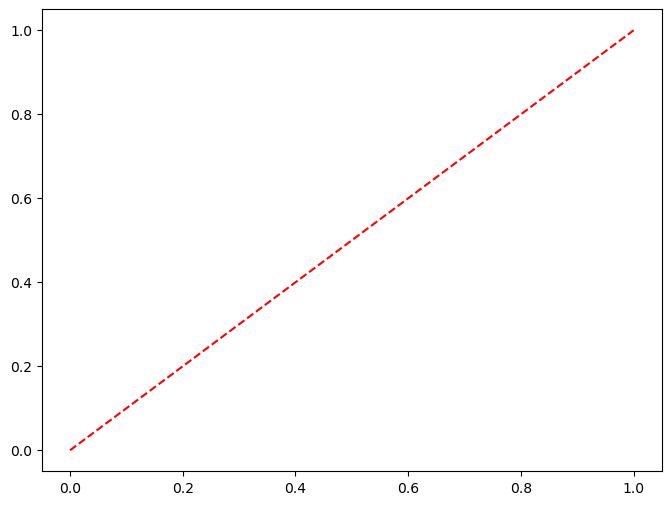

In [13]:
trainer.roc_curve()

In [7]:
trainer.anomaly_score_dist(is_pred=True ,bins=50)


<<<<<<<<<<<< ANOMALY SCORE DISTRIBUTION (PRED_LABEL) >>>>>>>>>>>>

Creating anomaly score distribution plot for (gearbox)-IF_fdet_1 / train...

Total OK samples (from pred_label) : 48
---------- Samples in OK bins ----------
Bin 0 (0.02395, 0.02434): 34 (1,001.035)
Bin 4 (0.02552, 0.02591): 27 (1,001.028), 44 (1,001.045)
Bin 5 (0.02591, 0.02631): 32 (1,001.033)
Bin 7 (0.02670, 0.02709): 37 (1,001.038)
Bin 9 (0.02748, 0.02788): 5 (1,001.006)
Bin 11 (0.02827, 0.02866): 26 (1,001.027)
Bin 12 (0.02866, 0.02905): 40 (1,001.041), 41 (1,001.042)
Bin 13 (0.02905, 0.02945): 33 (1,001.034)
Bin 16 (0.03023, 0.03062): 6 (1,001.007)
Bin 19 (0.03141, 0.03180): 18 (1,001.019), 23 (1,001.024), 30 (1,001.031)
Bin 20 (0.03180, 0.03219): 0 (1,001.001), 47 (1,001.048)
Bin 21 (0.03219, 0.03258): 17 (1,001.018), 29 (1,001.030), 35 (1,001.036), 38 (1,001.039)
Bin 22 (0.03258, 0.03298): 3 (1,001.004), 11 (1,001.012), 14 (1,001.015), 28 (1,001.029)
Bin 23 (0.03298, 0.03337): 19 (1,001.020), 21 (1,001.022), 39


Creating prediction plot for OneClassSVM / train...

Prediction plot not logged as logging is disabled.


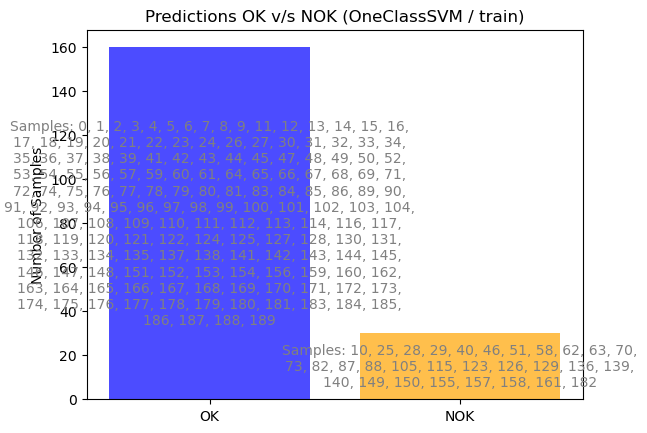

In [12]:
trainer.pred_plot()

### Test model

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
from settings.manager import get_model_pickle_path

# load trained model
trained_anomaly_detector = AnomalyDetector.load_from_pickle(get_model_pickle_path("C:\\Aryan_Savant\\Thesis_Projects\\my_work\\AFD_thesis\\fault_detection\\logs\\bearing\\cwru\\scene_1\\train\(gearbox)\\1SVM\\(gearbox)-1SVM_fdet_5"))

# update its data stats
trained_anomaly_detector.data_stats = test_data_stats

# initialize logger for testing
if fdet_config.is_log:
    test_logger = SummaryWriter(log_dir=fdet_config.get_test_log_path())
else:
    test_logger = None

# initialize tester
tester = TrainerAnomalyDetector(logger=test_logger)
tester.test(trained_anomaly_detector, test_loader)


Test accuracy: 0.96


## Custom Test

In [8]:
# new data
data_config.set_custom_test_dataset()

custom_test_data = data_preprocessor.get_custom_data(data_config)

custom_test_loader = custom_test_data[0]
custom_test_data_stats = custom_test_data[1]

Total samples: 12168, Desired samples: 7300, Remainder samples: 4868


In [9]:
from settings.manager import AnomalyDetectorPredictManager
import inspect
pred_config = AnomalyDetectorPredictManager(data_config)

trained_anomaly_detector = AnomalyDetector.load_from_pickle(pred_config.ckpt_path)

anomaly_detector.data_stats = custom_test_data_stats

In [10]:
from detector import TrainerAnomalyDetector
from torch.utils.tensorboard import SummaryWriter

custom_test_log_path = pred_config.get_custom_test_log_path()

# initialize logger
if fdet_config.is_log:
    pred_config.save_custom_test_params()
    logger = SummaryWriter(custom_test_log_path)
else:
    logger = None

# initialize trainer
tester = TrainerAnomalyDetector(logger=logger)
tester.test(trained_anomaly_detector, custom_test_loader)

custom_test number 1 for already exists for (gearbox)_fault_detector_7 in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)
\(gearbox)_fault_detector_7\(gearbox)_custom_test_1'.

Overwrote version 1 from the log path 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\
(gearbox)_fault_detector_7\(gearbox)_custom_test_1.

Custom test parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\
(gearbox)_fault_detector_7\(gearbox)_custom_test_1.

Test accuracy: 0.99


## Other stuff

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import os
from data.config import DataConfig
from settings.manager import AnomalyDetectorTrainManager

data_config = DataConfig(run_type="custom_test")
fdet_config = AnomalyDetectorTrainManager(data_config)

log_path = fdet_config.get_train_log_path(600, 1)
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_params()

'Version 1' already exists in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_
gearbox)_fault_detector_1'.

Next model number folder will be: (1_gearbox)_fault_detector_10

c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_gearbox)_fault_detector_10


Model parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_g
earbox)_fault_detector_10.

predict

In [3]:
import os
from data.config import DataConfig
from fault_detection.config import PredictAnomalyDetectorConfig

fdet_config = PredictAnomalyDetectorConfig()

data_config = DataConfig()
data_config.set_predict_dataset()

log_path = fdet_config.get_predict_log_path()
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_predict_params()

c:\AFD\fault_detection\logs\bearing\cwru\scene_1\predict\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_predict_1
Predict parameters saved to c:\AFD\fault_detection\logs\bearing\cwru\scene_1\predict\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_predict_1.


test

In [2]:
import os
from data.config import DataConfig
from fault_detection.config import PredictAnomalyDetectorConfig

fdet_config = PredictAnomalyDetectorConfig()

data_config = DataConfig()
data_config.set_custom_test_dataset()

log_path = fdet_config.get_custom_test_log_path()
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_custom_test_params()


custom_test number 1 for already exists for (gearbox)_fault_detector_1 in the log path 'c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1'.
Removed version 1 from the log path c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1.
c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1
Custom test parameters saved to c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1.


In [3]:
from fault_detection.config import SelectFaultDetectionModel

model_selector = SelectFaultDetectionModel(run_type="train")
                                           
model_selector.select_model_and_params()

bearing
└── cwru
    └── scene_1 (trained models)
        ├── <node_name>
        └── (gearbox)
            ├── <ds_type>
            └── healthy_unhealthy
                ├── <ds_subtype>
                └── 0_N[OG, gau_m=0.1s=0.2, gau_m=0.2s=0.3] + 0_B-007[gau_m=0.0s=0.1, gau_m=0.1s=0.2] + 0_B-021[OG]
                    ├── <model>
                    └── [anom] IF
                        ├── <ds_stats>
                        └── T500 [acc]
                            ├── <domain>
                            └── time
                                ├── <fex_type>
                                ├── (anom) [first_n_modes]
                                │   ├── <shape_compatibility>
                                │   └── anom (comps = 500)
                                │       ├── <versions>
                                │       └── (gearbox)_fault_detector_1 (v1) [0]
                                └── (anom) [no_fex]
                                    ├── <shape_compatibility>
                                    └── anom (comps = 500)
                                        ├── <versions>
                                        └── (gearbox)_fault_detector_2 (v1) [1]


Available version paths:
0: c:\AFD\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\(gearbox)_fault_detector_1
1: c:\AFD\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\(gearbox)_fault_detector_2


ValueError: invalid literal for int() with base 10: ''